# Airfoil contour analysis

CEBECI windtunnel conformal mapping.

Study contour of airfoil used there.

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import scipy.interpolate as spi
import scipy.linalg as sla

import copy

%matplotlib inline

In [2]:
def read_airfoil_coordinates(filename):
    with open(filename, 'r') as f:
        data = f.readlines()
        data = [line for line in data if not '#' in line]
        x = [float(l.split()[0]) for l in data]
        y = [float(l.split()[1]) for l in data]
        return x, y

In [6]:
airfoil_name = 'NACA0012'
filename = '../Aerodynamics/NACA0012.txt'
x, y = read_airfoil_coordinates(filename)

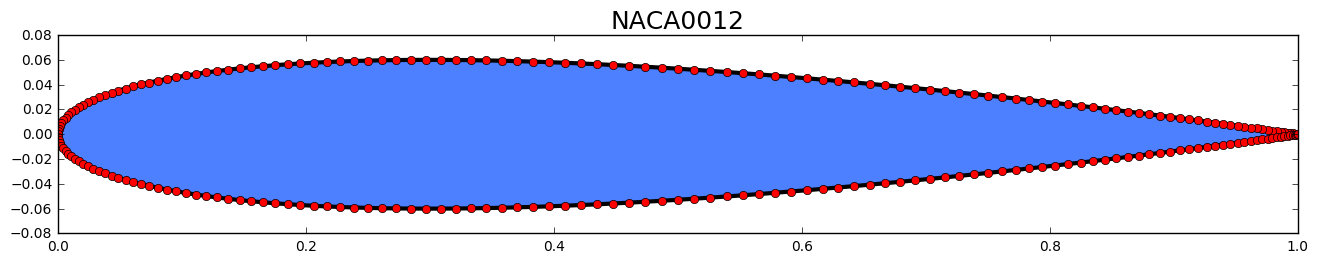

In [20]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 1, 1)

ax.plot(x,y, 'k', linewidth=3)
ax.plot(x,y, 'ro', linewidth=3)
ax.set_xlim(0.0, 1.0)
ax.set_ylim(-0.08, 0.08)
ax.set_title(airfoil_name, fontsize=18)
ax.fill(x, y, color=(0.3, 0.5, 1))
ax.set_aspect('equal')

In [8]:
def refine(x, y, tol=170.0, recursions=0):
    """Recursive refinement with respect to angle criterion (tol)"""

    xn = copy.deepcopy(x)
    yn = copy.deepcopy(y)
    
    j = 0
    refinements = 0
    refined = False
    first = True
    
    for i in range(len(x)-2):
        
        a = np.array([x[i] - x[i+1], y[i] - y[i+1]])
        b = np.array([x[i+2] - x[i+1], y[i+2] - y[i+1]])
        angle = angle_degree(a, b)
        
        if angle < tol:
            if first and recursions > 0:
                print '\nRecursion level: ', recursions
                first = False
            refinements += 1
            print 'Refining around point', i+1, angle, tol

            # calculate spline through original contour x, y
            coo, u, t, der1, der2, tck = spline(x, y, 500, False)

            # put refinement points on spline contour
            p1 = spi.splev((u[i+1]+u[i])/2, tck, der=0)
            p2 = spi.splev((u[i+2]+u[i+1])/2, tck, der=0)

            #
            if refined:
                xn = np.insert(xn, i+2+j, p2[0])
                yn = np.insert(yn, i+2+j, p2[1])
                j += 1
            else:
                xn = np.insert(xn, i+1+j, p1[0])
                yn = np.insert(yn, i+1+j, p1[1])
                xn = np.insert(xn, i+3+j, p2[0])
                yn = np.insert(yn, i+3+j, p2[1])
                j += 2
            
            refined = True
        else:
            refined = False
            
    # recursive refinement
    if refinements > 0:
        # print '\nRecursion level: ', recursions+1
        xn , yn = refine(xn , yn, tol, recursions+1)
    else:
        print '\nNumber of recursions: ', recursions-1
        print 'No more refinements.'
    
    return xn, yn

def angle_degree(a, b):
    """Return angle between two vectors"""
    dot = np.dot(a, b)
    na = sla.norm(a)
    nb = sla.norm(b)
    cosinus = dot / (na * nb)
    angle = np.arccos(cosinus)* 180.0 / np.pi

    return angle

In [9]:
def spline(x, y, num=200, ev=False):
    """Interpolate spline through given points"""

    # interpolate B-spline through data points
    # returns knots of B-spline ontrol polygon
    # tck ... tuple (t,c,k) containing the vector of knots, the B-spline coefficients, and the degree of the spline.
    # u ... array of the parameters; defines parameter for given points on the spline
    tck, u = spi.splprep([x, y], s=0, k=4)

    # number of points on interpolated B-spline (parameter t)
    t = np.linspace(0.0, 1.0, num)
    # in this case spline is only evaluated at the points (x, y) instead of num points otherwise
    if ev:
        t = u

    # evaluate B-spline at given parameters (der=0: returns point coordinates)
    coo = spi.splev(t, tck, der=0)

    # evaluate 1st derivative at given parameters
    der1 = spi.splev(t, tck, der=1)

    # evaluate 2nd derivative at given parameters
    der2 = spi.splev(t, tck, der=2)

    return coo, u, t, der1, der2, tck

In [10]:
xo = copy.deepcopy(x)
yo = copy.deepcopy(y)

# refine initial contour data with angle criterion
xn, yn = refine(xo, yo, 169.0)

# interpolate spline through refined contour polygon
coo, u, t, der1, der2, tck = spline(xn, yn, 601, False)


Number of recursions:  -1
No more refinements.


In [11]:
# der1 is dx/dt and dy/dt at each point
# der2 is d2x/dt2 and d2y/dt2 at each point

# gradient dy/dx = dy/du / dx/du
gradient = der1[1] / der1[0]

# radius of curvature for a parametric curve (B-spline in this case)
xd = der1[0]
yd = der1[1]
x2d = der2[0]
y2d = der2[1]
n = xd**2+ yd**2
d = xd*y2d-yd*x2d
# radius of curvature
R = n**(3./2.) / abs(d)
# curvature
C = d / n**(3./2.)
# coordinates of curvature-circle center points
xc = coo[0] - R * yd / np.sqrt(n)
yc = coo[1] + R * xd / np.sqrt(n)

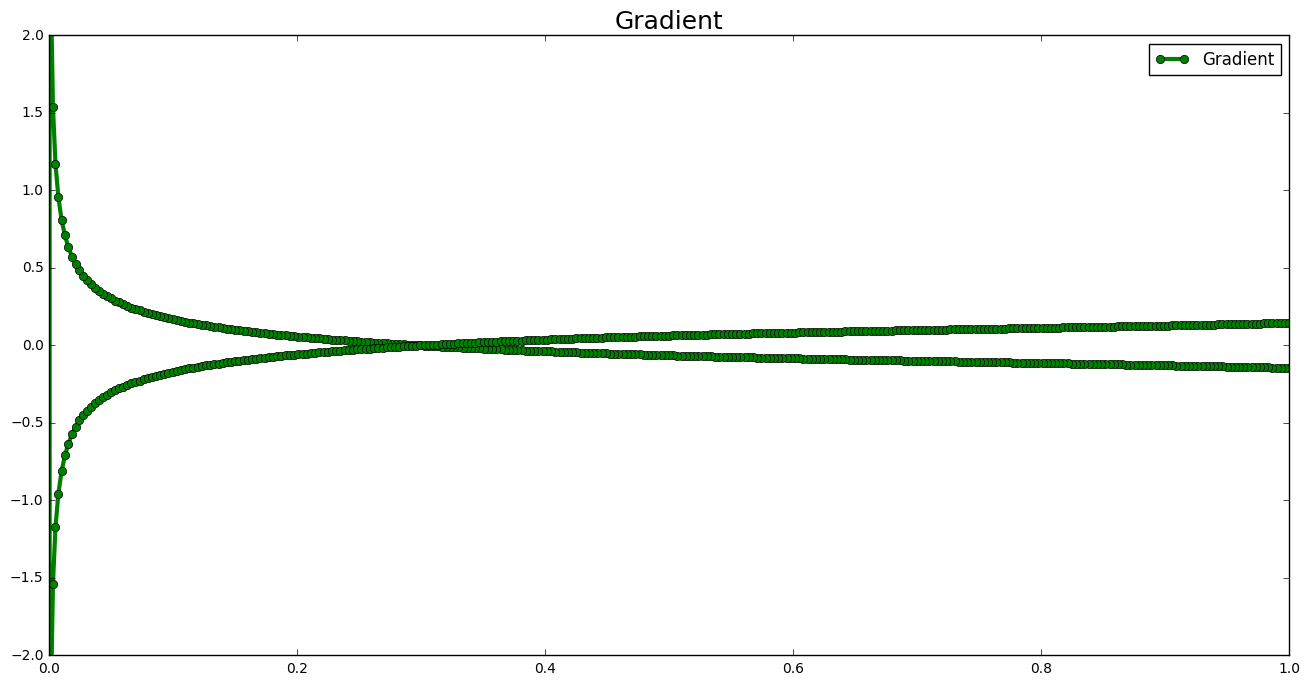

In [12]:
fig2 = plt.figure(figsize=(16, 8))
ax2 = fig2.add_subplot(1,1,1)
ax2.plot(coo[0], gradient,'go-', label='Gradient', linewidth=3)
ax2.set_title('Gradient', fontsize=18)
ax2.set_xlim(0.0, 1)
ax2.set_ylim(-2., 2)
ax2.legend(loc='best')

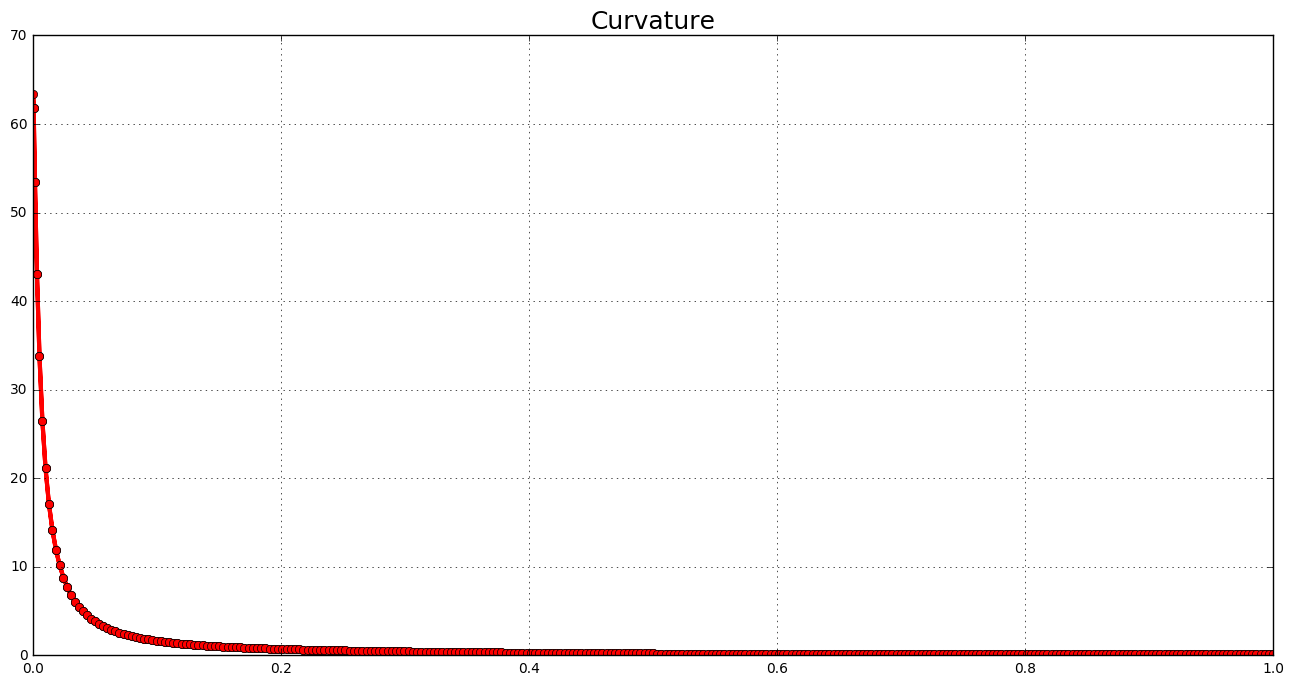

In [13]:
fig3 = plt.figure(figsize=(16, 8))
ax3 = fig3.add_subplot(1,1,1)
ax3.plot(coo[0], C,'ro-', linewidth=3)
ax3.set_title('Curvature', fontsize=18)
ax3.set_xlim(0.0, 1.0)
#ax3.set_ylim(0.0, 1.0)
ax3.grid()

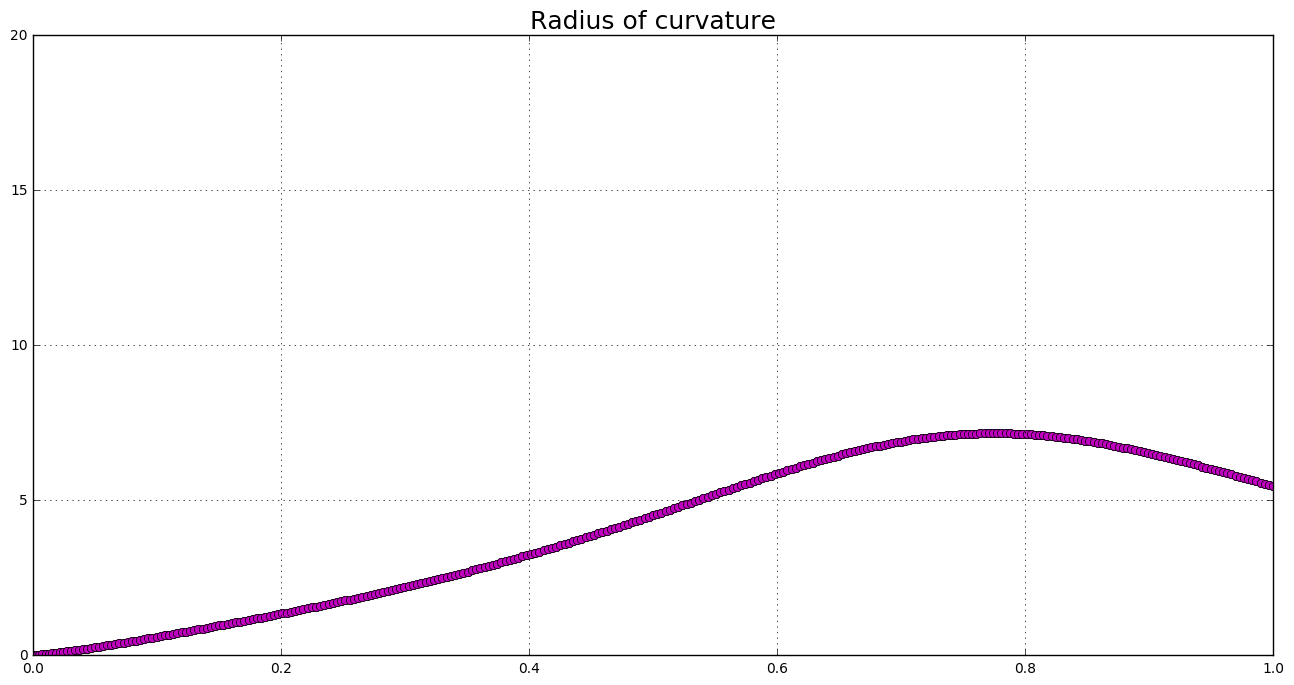

In [14]:
fig4 = plt.figure(figsize=(16, 8))
ax4 = fig4.add_subplot(1,1,1)
ax4.plot(coo[0], R,'mo-', linewidth=3)
ax4.set_title('Radius of curvature', fontsize=18)
ax4.set_xlim(0.0, 1.0)
ax4.set_ylim(0.0, 20.)
ax4.grid()
#ax4.set_aspect(1)

In [15]:
# identify leading edge radius (i.e. smallest radius of parametric curve)
r = np.min(R)
le_id = np.where(R == r)
# leading edge curvature circle center
xr = xc[le_id]
yr = yc[le_id]

In [16]:
circle = patches.Circle( (xr, yr) , r, edgecolor='y', facecolor='None', linewidth=3, zorder=10, ls='dotted')

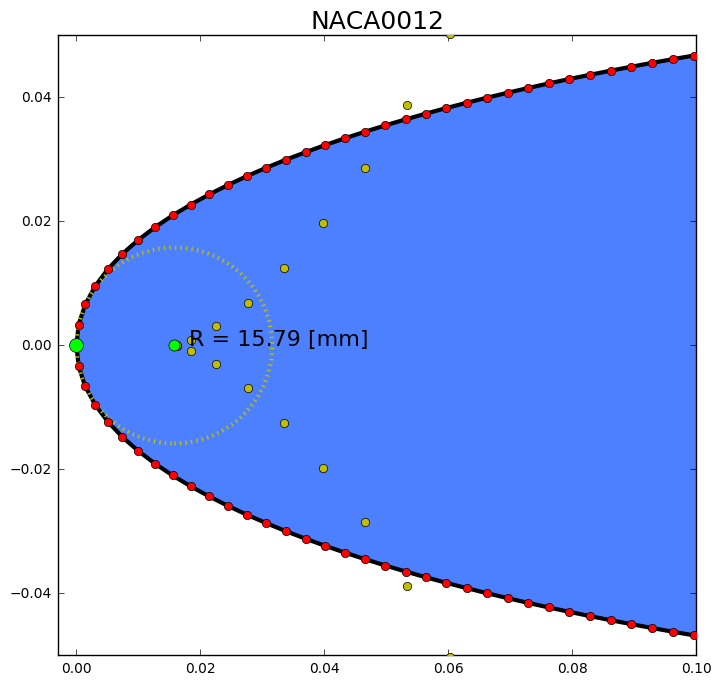

In [17]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
# points on spline through refined contour data
ax.plot(coo[0], coo[1], 'k', linewidth=3)
# points on spline through refined contour data
ax.plot(coo[0], coo[1], 'ro', zorder=20)
# curvature circle center points
ax.plot(xc, yc, 'yo', zorder=40)
# leading edge point
ax.plot(coo[0][le_id], coo[1][le_id], marker='o', zorder=50, color='lime', markersize=10)
# leading edge curvature circle center
ax.plot(xr, yr, marker='o', zorder=50, color='lime', markersize=8)
# leading edge curvature circle
ax.add_patch(circle)
ax.set_xlim(-0.003, .1)
ax.set_ylim(-0.05, 0.05)
ax.set_title(airfoil_name, fontsize=18)
ax.fill(coo[0], coo[1], color=(0.3, 0.5, 1))
ax.set_aspect('equal')
ax.text(1.15*xr, yr, 'R = '+ str(np.round(r, 5)*1000)+' [mm]', fontsize=16, zorder=60)